In [2]:
#
# Working through the example from
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_7_concentration_input.py
#

In [3]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [5]:
filename = 'Ex_1_C_data.txt'
C_frame = read_file(filename, directory = '../data_sets')

read dir : /home/paperspace/learn_kipet/kipet_examples/../data_sets/Ex_1_C_data.txt


In [6]:
C_frame

,A,B,C
0.0000,0.001027,0.000000,0.000013
0.0333,0.001015,0.000002,0.000021
0.0667,0.001007,0.000013,0.000018
0.1000,0.000993,0.000025,0.000014
0.1334,0.000982,0.000035,0.000012
...,...,...,...
9.8353,0.000103,0.000043,0.000859
9.8686,0.000104,0.000042,0.000857
9.9020,0.000103,0.000041,0.000859
9.9353,0.000101,0.000043,0.000860


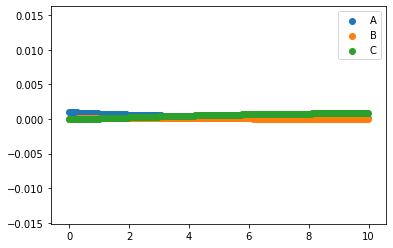

In [7]:
fig, ax = plt.subplots()
ax.scatter(C_frame.index, C_frame['A'], label = 'A')
ax.scatter(C_frame.index, C_frame['B'], label = 'B')
ax.scatter(C_frame.index, C_frame['C'], label = 'C')
ax.legend()

In [8]:
builder = TemplateBuilder()    
components = {'A':1e-3,'B':0,'C':0}
builder.add_mixture_component(components)
builder.add_parameter('k1',bounds=(0.0,5.0))
builder.add_parameter('k2',bounds=(0.0,1.0))
builder.add_concentration_data(C_frame)

               A         B         C
0.0000  0.001027  0.000000  0.000013
0.0333  0.001015  0.000002  0.000021
0.0667  0.001007  0.000013  0.000018
0.1000  0.000993  0.000025  0.000014
0.1334  0.000982  0.000035  0.000012
...          ...       ...       ...
9.8353  0.000103  0.000043  0.000859
9.8686  0.000104  0.000042  0.000857
9.9020  0.000103  0.000041  0.000859
9.9353  0.000101  0.000043  0.000860
9.9687  0.000103  0.000038  0.000863

[300 rows x 3 columns]


In [9]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs
    
builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,10.0)

In [10]:
sigmas = {'A':1e-10,'B':1e-11,'C':1e-10}

In [11]:
# and define our parameter estimation problem and discretization strategy
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=60,ncp=3,scheme='LAGRANGE-RADAU')

    number of finite elements specified in apply. The larger number of finite
    elements will be used.


In [12]:
# Again we provide options for the solver, this time providing the scaling that we set above
options = dict()
#options['nlp_scaling_method'] = 'user-scaling'
options['linear_solver'] = 'ma27'

In [13]:
# finally we run the optimization
results_pyomo = p_estimator.run_opt('ipopt',
                                        variances=sigmas,
                                      tee=True,
                                   solver_opts = options)

Ipopt 3.12: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    23403
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2700

Total number of variables............................:     5405
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5403
Total

In [14]:
# And display the results
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 0.22583748189276387
k2 0.991207923892835


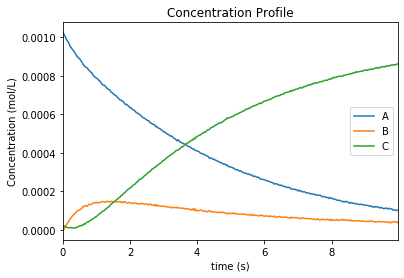

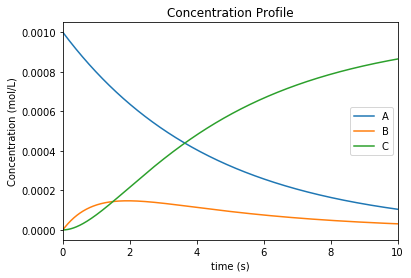

In [15]:
results_pyomo.C.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")

results_pyomo.Z.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")


plt.show()